### CBSA Map - splitting large metro areas

Using the CPS to do anything below the state level starts to get tricky, with the exception of the major cities.

In some cases, mapping CPS data to metro areas gives disappointing results. One example is the DC metro area, where the West Virginia observations aren't identified in the CPS public use microdata. The area includes DC itself, which has many observations and often different outcomes than the suburbs. 

In [1]:
# Import packages
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import os
import shapely.geometry as sg

os.chdir('/home/brian/Documents/CPS/data/clean/')
path = '/home/brian/Documents/econ_data/micro/shapefiles'

In [2]:
cols = ['CBSA', 'YEAR', 'MONTH', 'AGE', 'LFS', 'FEMALE',
        'BASICWGT', 'STATE', 'WBHAO']
CBSA_id = 47900
states_list = ['MD', 'VA', 'DC', 'WV']

df = (pd.read_feather(f'cps2019.ft', columns=cols)
        .query('CBSA == @CBSA_id and 16 <= AGE and FEMALE == 1'))
df.groupby(['STATE', 'LFS']).BASICWGT.count().unstack().loc[states_list]

LFS,Employed,NILF,Unemployed,nan
STATE,,,,
MD,1778,868,64,0
VA,2545,1290,51,0
DC,5905,2942,290,0
WV,0,0,0,0


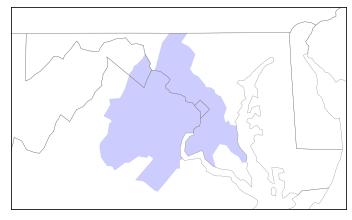

In [3]:
# Show DC Area in detail
m = Basemap(llcrnrlon=-79.7, llcrnrlat=37.8, urcrnrlon=-75, urcrnrlat=40,
            projection='lcc', lat_1=1, lat_2=0, lon_0=-95)

fig, ax = plt.subplots()
m.readshapefile(f'{path}/cb_2019_us_state_20m', 'states', 
                color='gray', linewidth=0.3)
m.readshapefile(f'{path}/cb_2019_us_cbsa_20m', 'cbsa', drawbounds=False)

seg = [shape for info, shape in zip(m.cbsa_info, m.cbsa) 
       if info['GEOID'] == str(CBSA_id)][0]
ax.add_patch(Polygon(seg, fc='blue', ec='gray', lw=0.18, alpha=0.2))
plt.show()

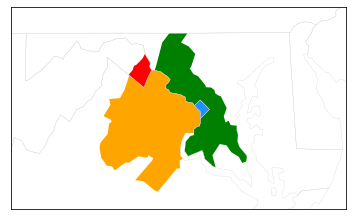

In [5]:
d = {}
for info, shape in zip(m.states_info, m.states):
    if info['STUSPS'] in states_list: 
        d[info['STUSPS']] = sg.Polygon(seg).intersection(sg.Polygon(shape))
        
dseg = {}
for st in states_list:
    if type(d[st]) == sg.Polygon:
        dseg[st] = d[st]
    else:
        dseg[st] = [i for i in d[st] if hasattr(i, 'exterior') == True][0]
        
# facecolor for each state
fc = {'MD': 'green', 'VA': 'orange', 'DC': 'dodgerblue', 'WV': 'red'}

# Show DC Area in detail
fig, ax = plt.subplots()
m.readshapefile(f'{path}/cb_2019_us_state_20m', 'states', 
                color='lightgray', linewidth=0.3)
m.readshapefile(f'{path}/cb_2019_us_cbsa_20m', 'cbsa', 
                drawbounds=False)

for k, shape in dseg.items():
    ax.add_patch(Polygon(shape.exterior, fc=fc[k]))

plt.show()